In [6]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import PoissonRegressor
import pyreadr
# matplotlibで日本語を使えるように
plt.rcParams["font.family"] = "IPAGothic"

In [7]:
data = pd.read_csv("data3a.csv")

In [8]:
Rdata_path = "d0.RData"
# Rdataを読み込み
result = pyreadr.read_r(Rdata_path)
# dataは個体に対しての種子数のカウント数
data2 = result["d0"]

<h1>3 一般化線形モデル(GLM)</h1>

この章では説明変数を組み込んだ統計モデルについて扱う。  
第二章のモデルでは平均種子数$λ$は全個体で共通だとしてきた。  
ここでは個体ごとに異なる説明変数によって平均種子数$λ_i$が変化する統計モデルを扱う。  
このような統計モデルを観測データにあてはめることをポアソン回帰といい、これと似たような構造の統計モデルを総称して、一般化線形モデルという。

<h1>3.1 例題: 個体ごとに平均種子数が異なる場合</h1>

植物個体$i$の種子数は$y_i$個であり、さらに個体$i$の体の大きさを$x_i$  
全個体のうち半分の50個体は何も処理をしていないコントロール群とし、残り50個体には肥料を与える処理をしたとする。  
個体の大きさ$x_i$とは無関係に施肥処理が行われたとします。  

<h1>3.2 観測されたデータの概要を調べる<h1>

In [9]:
# データを表示
data

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C
...,...,...,...
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T


In [10]:
# データ型を表示
data.dtypes

y      int64
x    float64
f     object
dtype: object

In [11]:
# データの統計値を表示
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


In [12]:
# Cが施肥処理なし、Tが施肥処理あり
unique_f = data["f"].unique()
for f in unique_f:
  f_len = len(data[data["f"]==f])
  print(f"施肥処理{f}のサイズ: {f_len}個")

施肥処理Cのサイズ: 50個
施肥処理Tのサイズ: 50個


<h1>3.3 統計モデリングの前にデータを図示する</1>

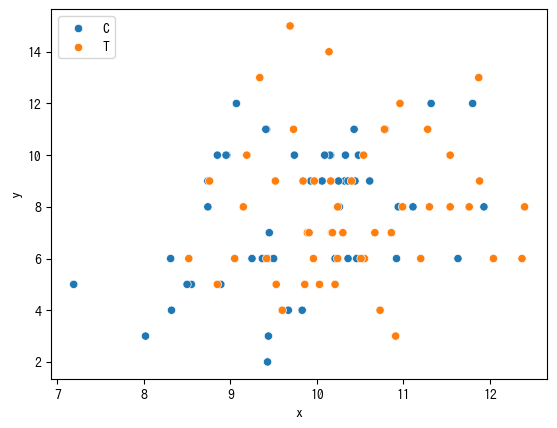

In [13]:
# xとyの関係性を見てみる
sns.scatterplot(data,x="x",y="y",hue="f")
plt.legend(loc="upper left")
plt.show()

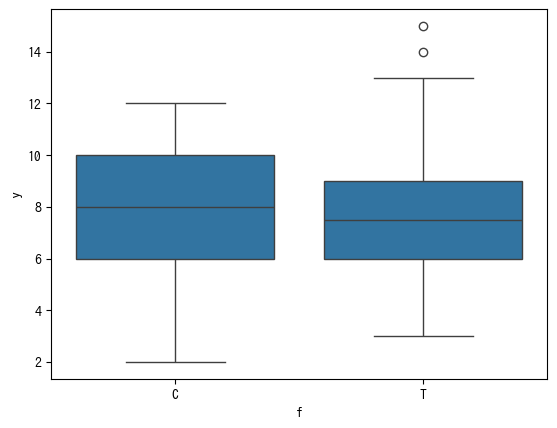

In [14]:
# fとyの関係性を見てみる
sns.boxplot(data,y="y",x="f")
plt.show()

これらの図をみて、なんとなくわかることは  
・体サイズ$x$が増加するにつれて、種子数$y$が増えているように見えるけどあまりはっきりしない  
・肥料の効果$f$は全然無いように見える  

<h1>3.4 ポアソン回帰の統計モデル</h1>

前の章では平均種子数$λ$は全個体で共通の値とした。  
この章の例題では個体ごとの平均種子数$λ_i$が体サイズ$x_i$や施肥処理$f_i$に影響されるモデルを設計する  
  
とりあえず施肥処理$f_i$はあまり種子数に影響がなさそうなので体サイズ$x_i$だけに依存するモデルを考えてみる。  
説明変数は$x_i$だけであり、応答変数は種子数$y_i$とする。  
ある個体$i$において種子数が$y_i$である確率$p(y_i|λ_i)$はポアソン分布に従い、  
$p(y_i|λ_i)=\frac{λ_i^{y_i}exp(-λ_i)}{y_i!}$  
と仮定します


<h2>3.4.1 線形予測子と対数リンク関数</h2>

平均種子数$λ_i$を説明変数$x_i$の関数として定義する必要がある。  
$λ_i=exp(β1+β2x_i)$であるとしてみる。  
$β1$、$β2$はパラメータでありそれぞれ切方、傾きと呼ばれる。  
このモデルの数式は、  
$log(λ_i)=β1+β2x_i$と変形でき、  
この右辺は{$β1$、$β2$}の線形結合になっており一般化線形モデルでは線形予測子と呼ばれる。  
($λ_i$の関数)=(線形予測子)となっている場合、左辺の「関数」はリンク関数と呼ばれる。  
この場合は$log$が使われているので対数リンク関数と呼ばれる。ポアソン回帰では、たいていの場合対数リンク関数が使われる。  

ポアソン回帰の一般化線形モデルでは対数リンク関数、  
ロジスティック回帰の一般化線形モデルではロジットリンク関数がよく使われ、  
ポアソン分布、二項分布の正準リンク関数と呼ばれる。  
  
ポアソン回帰で対数リンク関数を使う理由は「推定結果に都合よく」「わかりやすい」からです。  
ポアソン分布の$λ$は非負でなければならず、  
対数リンク関数$λ_i=exp(β1+β2x_i)$は説明変数やパラメータがどのような値になっても必ず非負となるため「推定結果に都合がよい」。  
また、要因の効果が積であらわされるため「わかりやすい」のである。  
$exp(x_i+1)=exp(x_i)*exp(1)$となって説明変数が1増えると$λ_iはexp(1)$倍されることがわかる。  
  
以下の図は$λ_i=exp(β1+β2x_i)$とした時に平均種子数$λ_i$と体サイズ$x_i$の関係


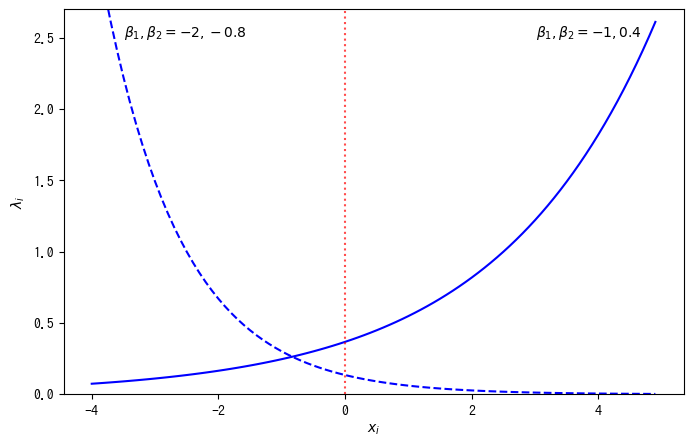

In [15]:
b1s=[-2,-1]
b2s=[-0.8,0.4]
x=np.arange(-4,5,0.1)
y_lim = 2.7

plt.figure(figsize=(8,5))
for b1,b2 in zip(b1s,b2s):
  if b2 < 0:
    linestyle = '--'
    ha = "left"
    x_pos = (np.log(y_lim-0.1)-b1)/b2 + 0.2
  else:
    linestyle = None
    ha = "right"
    x_pos = (np.log(y_lim-0.1)-b1)/b2 - 0.2
  lam = np.exp(b1+b2*x)
  # グラフ
  plt.plot(x,lam, color="blue",linestyle=linestyle) 
  plt.text(x=x_pos,y=2.6,
           s=rf"$\beta_1,\beta_2={b1},{b2}$",
           ha=ha,
           va="top"
          )
# x=0の点に縦線を引く
plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)

plt.ylim(0, y_lim)
plt.xlabel(r"$x_i$")
plt.ylabel(r"$λ_i$")
plt.show()

<h2>3.4.2 あてはめとあてはまりのよさ</h2>

ポアソン回帰とは、観測データに対するポアソン分布を使った統計モデルのあてはめであり、  
対数尤度$logL$が最大になる$\beta_1と\beta_2$の推定値を求めること。  
このモデルの対数尤度は$logL(\beta_1,\beta_2)=\sum_i log(\frac{λ_i^{y_i}exp(-λ_i)}{y_i!})$となり  
線形予測子は$logλ_i=\beta_1+\beta_2$であり$λ_iが\beta_1と\beta_2$の関数になっている。  
ここでは$\beta_1$、$\beta_2$の最尤推定量の解析的な導出はせず、数値的な試行錯誤によって最尤推定値を探し出す  

In [16]:
"""
ライブラリの選択基準
statsmodels:	回帰結果の統計量（p 値、信頼区間など）が充実
scikit-learn:	大規模データ向け、高速、正則化あり、機械学習向け
統計解析したい → statsmodels
予測モデルを作りたい → scikit-learn
"""
# 説明変数に切片を追加
X = sm.add_constant(data[["x"]])

# ポアソン回帰
model = sm.GLM(data["y"], X, family=sm.families.Poisson()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Sun, 30 Nov 2025   Deviance:                       84.993
Time:                        02:02:52   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.0

上側部分の見方を説明する。
 
Dep. Variable: y  
→目的変数  
No. Observations: 100  
→データ数  
Model Family: Poisson	  
→ポアソン回帰  
Link Function: Log  
→リンク関数。$log(λ_i)=\beta_1+\beta_2x_i$  
Df Residuals: 98  
→残差の自由度  
Df Model: 1  
→モデルの自由度   
Log-Likelihood: -235.39  
→対数尤度  
Deviance : 84.993  
→逸脱度、モデルの当てはまりの悪さを表す。$\frac{逸脱度}{残渣の自由度}$が1に近いほどよい  
Pearson chi2   
→ピアソンのカイ二乗統計量。 $\frac{χ^2}{残渣の自由度}$が1に近いほどよい  
Pseudo R-squ.  
→決定係数R²の近似。近似があまりよくないので参考にしない    

下側部分の見方を説明する。  
  
「const」は切片$\beta_1$、xは係数の傾き$\beta_2$に対応。  
「coef」は最尤推定値のこと。$\hat\beta_1=1.2917$、$\hat\beta_2=0.0757$となっている。  
「std err」はパラメータの標準偏差の推定値。$\hat\beta_1$と$\hat\beta_2$の「ばらつき」を標準偏差で表したもの。  
パラメータの推定値のばらつきとは「同じ調査方法で同数の別データをとりなおしても最尤推定値は変動する。そのばらつきぐあい」  
「z」はz値と呼ばれる統計量であり$\frac{最尤推定値}{標準誤差}$で見積もられる。  
「P>|z|」はp値と呼ばれる統計量であり、この値が大きいほどz値が0に近く推定値が0に近いことを表す(効果がない)。  
下の図の黒く塗りつぶされている面積の二倍  
「[0.025, 0.975]」は信頼区間  
  
ある説明変数をモデルに含めるか否かの判断はこのような統計量を使うのではなく、クロスバリデーションやAICを用いた予測誤差に基づいた方法により判断した方がよいかもしれない。  
「この説明変数をいれるかどうか」といった判断はあてはまりの改善ではなく、予測の改善を目的としているから  


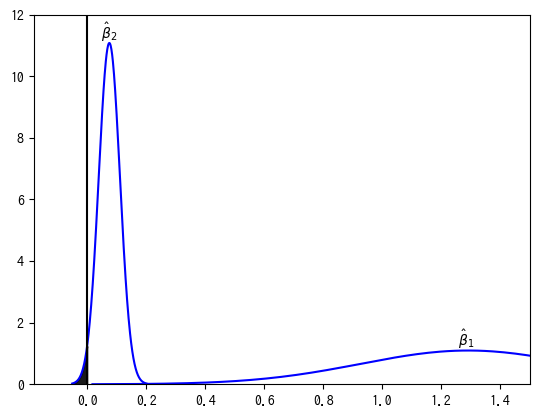

In [17]:
# パラメータのz検定の有意な部分を塗りつぶす
b_coefs=[1.2917,0.075]
b_stds=[0.364,0.036]
for i, b_coef,b_std in zip([1,2],b_coefs,b_stds):
  # プロット範囲
  x = np.linspace(b_coef - 3.5*b_std, b_coef + 3.5*b_std, 200)
  # 正規分布の密度
  y = norm.pdf(x, loc=b_coef, scale=b_std)
  # テキストを入れる座標
  max_idx = np.argmax(y)
  max_x = x[max_idx]
  max_y = y[max_idx]
  # 有意になる部分の面積
  mask = x<0
  x_fill = x[mask]
  y_fill = y[mask]

  plt.plot(x, y,color="blue")
  plt.text(x=max_x,y=max_y,
           s=fr"$\hat{{\beta}}_{i}$",
           ha="center",
           va="bottom"
          )
  if(len(x_fill)>0):
    plt.fill_between(x_fill,y_fill, color='black', alpha=0.9)
plt.axvline(0,color="black",linestyle="-")
plt.xlim(right=1.5)
plt.ylim([0,12])
plt.show()

<h2>3.4.3 ポアソン回帰モデルによる予測</h2>

このポアソン回帰の推定結果を使って、さまざまな体サイズxにおける平均種子数$λ$の予測をしてみる  
下の図は観測値に先ほど求めたポアソン回帰モデルの予測線を引いたもの

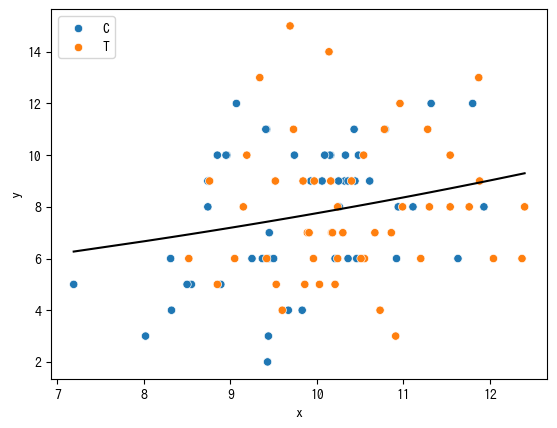

In [18]:
pred = model.predict(X)
# xとyの関係性を見てみる
sns.scatterplot(data,x="x",y="y",hue="f")
x_sorted_idx = np.argsort(data["x"])
plt.plot(data["x"].iloc[x_sorted_idx], pred.iloc[x_sorted_idx], color="black")
plt.legend(loc="upper left")
plt.show()

<h1>3.5 説明変数が因子型の統計モデル</h1>

次に、今まで放置していた施肥効果$f_i$を説明変数として組み込んだモデルを検討する  
$f_i$にはCとTの2水準あり、Cが施肥処理なし、Tが施肥処理ありの個体であった。  
施肥効果$f_i$を以下のダミー変数$d_i$に変換する。  
$d_i = 
\begin{cases}
0 & (f_i = C) \\
1 & (f_i = T)
\end{cases}$  
  

このように施肥効果$f_i$をダミー変数$d_i$に変換して、施肥処理だけが影響するポアソン回帰モデルを考えると  
$λ_i=exp(\beta_1+\beta_3d_i)$となって、  
$\beta_1$は切片、$\beta_3$は施肥の効果の有無を表すモデルとなる。  
個体$i$が施肥処理なし($f_i=C$)の場合は  
$λ_i=exp(\beta_1+\beta_3*0)$となって  
施肥処理あり($f_i=T$)の場合は  
$λ_i=exp(\beta_1+\beta_3*1)$となる   

In [19]:
d = data["f"]
print(f"欠損値の数を確認: {d.isna().sum()}")
print(f"因子C[施肥処理なし]の個数を確認: {(d=='C').sum()}")
print(f"因子T[施肥処理あり]の個数を確認: {(d=='T').sum()}")
# ダミー変数に変換
d = d.map({"C": 0, "T": 1})
# 説明変数に切片を追加
d = sm.add_constant(d)

# ポアソン回帰
model = sm.GLM(data["y"], d, family=sm.families.Poisson()).fit()

print(model.summary())

欠損値の数を確認: 0
因子C[施肥処理なし]の個数を確認: 50
因子T[施肥処理あり]の個数を確認: 50
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Sun, 30 Nov 2025   Deviance:                       89.475
Time:                        02:02:53   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0003192
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

もし個体$i$の$f_i$がCならば、  
$λ_i=exp(2.0516)=7.780$  
もし個体$i$の$f_i$がTならば、  
$λ_i=exp(2.0516+0.0128)=7.888$  
このモデルでは「肥料をやると平均種子数がほんの少しだけ増える」と予測しています。  
  
またこのモデルの最大対数尤度は$-237.63$となっており、  
体サイズ$x_i$を説明変数としたモデルの最大対数尤度$-235.39$より値が小さく当てはまりが悪くなっています  


因子型説明変数の水準数が3以上になる場合もあります。  
たとえば、一部の個体には「肥料A」を、また別の一部の個体には「肥料B」を与えるとする。  
説明変数$f_i$は{C ,A, B}の3水準が設定されますが、この場合は二つのダミー変数を使って表現すればよく、  
$d_{i,A} = 
\begin{cases}
0 & (f_iがAじゃない場合) \\
1 & (f_iがAの場合)
\end{cases}$  
$d_{i,B} = 
\begin{cases}
0 & (f_iがBじゃない場合) \\
1 & (f_iがBの場合)
\end{cases}$  
として、平均種子数$λ$は  
$λ_i=exp(\beta_1+\beta_3d_{i,A}+\beta_4d_{i,B})$として表現すればよい。

<h1>3.6 説明変数が数量型＋因子型の統計モデル</h1>

今度は個体の体サイズ$x_i$と施肥処理$f_i$の複数の説明変数を同時に組み込んだ統計モデルを作ってみる。  
一旦ここでは体サイズと施肥処理の交互作用については考慮しないこととする。  
$λ_i=exp(\beta_1+\beta_2x_i+\beta_3d_i)$  
となって、$\beta_1$は切片、$\beta_2$は体サイズの効果で、$\beta_3$が施肥処理の効果となる。 


In [20]:
d = data.copy()
d = d.drop("y",axis=1)
# 施肥処理fをダミー変数に変換
d["f"] = d["f"].map({"C": 0, "T": 1})
# 説明変数に切片を追加
d = sm.add_constant(d)

# ポアソン回帰
model = sm.GLM(data["y"], d, family=sm.families.Poisson()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Sun, 30 Nov 2025   Deviance:                       84.808
Time:                        02:02:54   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04590
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2631      0.370      3.417      0.0

この結果を見ると、施肥処理のみのモデルでは推定値がプラスであったのにこのモデルではマイナスになっています。  
肥料の効果についてはいよいよわからなくなりました。  
最大対数尤度は$-235.29$となっており$x_i$だけのモデルの最大対数尤度$-235.39$より少しだけ当てはまりがよくなっています。  
※モデルの性能は当てはまりの良さではなく、予測の良さで評価すべきではあるが・・・

<h2>3.6.1 対数リンク関数のわかりやすさ : 掛け算される効果</h2>

なぜ対数リンク関数では要因の効果が積であらわされるのか？について調べていく。  
体サイズ$x_i$と施肥処理$f_i$を用いたポアソン回帰モデルでは平均種子数$λ$は、  
$λ_i=exp(1.2631+0.0801x_i-0.0320d_i)$となったがこれは  
$λ_i=exp(1.2631)*exp(0.0801x_i)*exp(0.0320d_i)$と分解することができる。  
よって体サイズ$x_i$については「$x_i$が1増えると、$λ_i$は$exp(0.08*1)=1.08$倍に増える」と予測される。  
施肥処理に関しては「肥料を与えると$λ_i$は$exp(-0.0320)=0.969$倍になる」と予測される。  
このようにそれぞれの効果は平均種子数$λ_i$に対して掛け算で影響していることがわかる。  
よって$λ_i$に対して体サイズと施肥処理が与える影響は以下の図のように指数関数的なものとなる。

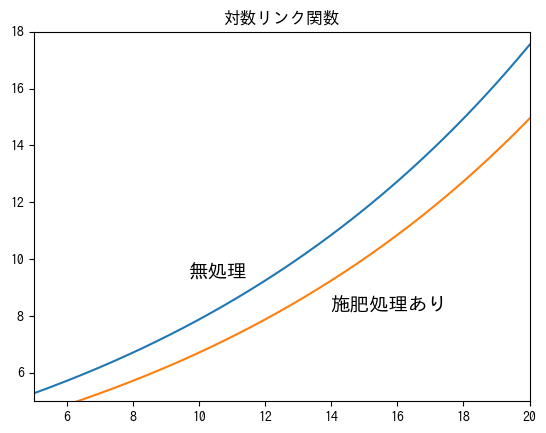

In [21]:
# xが0から20までの範囲で予測
x = np.linspace(0, 20, 200)
d = pd.DataFrame({"x":x})
# 施肥処理なし
d["f"] = 0
# 説明変数に切片を追加
d = sm.add_constant(d)
# 施肥処理なしで予測
y_not_f = model.predict(d)

# 施肥処理の効果をわかりやすいように五倍にする
d["f"] = 5
# 施肥処理ありで予測
y_f = model.predict(d)

# グラフを描写
plt.plot(x, y_not_f)
plt.plot(x, y_f)
# テキストを追加
y_pos = 9
# 施肥処理なし
plt.text(x=x[(y_not_f.astype(int)==y_pos).argmax()]-0.3,y=y_pos+0.3,
         s="無処理",ha="right",va="bottom", fontsize=14)
# 施肥処理あり
plt.text(x=x[(y_f.astype(int)==y_pos).argmax()]+0.3,y=y_pos-0.3,
         s="施肥処理あり",ha="left",va="top",fontsize=14)

plt.xlim(5,20)
plt.ylim(5,18)
plt.title("対数リンク関数")
plt.show()

もし対数リンク関数を使わないとどうなるだろうか？  
平均が線形予測子に等しいリンク関数を恒等リンク関数と呼ぶ。  
$λ_i=\beta_1+\beta_2x_i+\beta_3f_i$  
この恒等リンク関数を使ってポアソン回帰をしてみる。

In [22]:
d = data.copy()
d = d.drop("y",axis=1)
# 施肥処理fをダミー変数に変換
d["f"] = d["f"].map({"C": 0, "T": 1})
# 説明変数に切片を追加
d = sm.add_constant(d)

# ポアソン回帰(恒等リンク関数を使用)
model = sm.GLM(data["y"], d, 
              family=sm.families.Poisson(link=sm.genmod.families.links.identity())).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.16
Date:                Sun, 30 Nov 2025   Deviance:                       84.538
Time:                        02:02:54   Pearson chi2:                     83.6
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04847
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2671      2.843      0.446      0.6

/usr/local/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


平均種子数$λ_i$の予測は、  
$λ_i=1.2671+0.6606x_i+-0.2048d_i$となり、その予測は以下の図のようになる

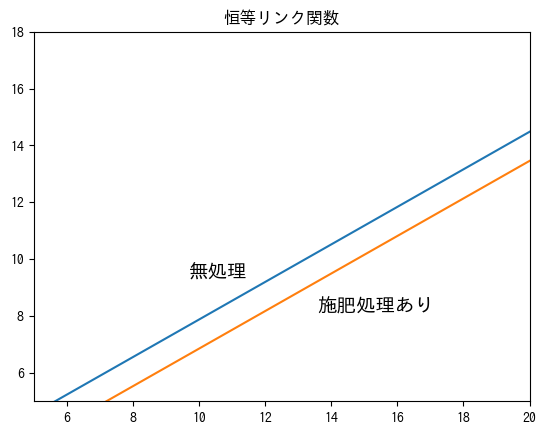

In [23]:
# xが0から20までの範囲で予測
x = np.linspace(0, 20, 200)
d = pd.DataFrame({"x":x})
# 施肥処理なし
d["f"] = 0
# 説明変数に切片を追加
d = sm.add_constant(d)
# 施肥処理なしで予測
y_not_f = model.predict(d)

# 施肥処理の効果をわかりやすいように五倍にする
d["f"] = 5
# 施肥処理ありで予測
y_f = model.predict(d)

# グラフを描写
plt.plot(x, y_not_f)
plt.plot(x, y_f)
# テキストを追加
y_pos = 9
# 施肥処理なし
plt.text(x=x[(y_not_f.astype(int)==y_pos).argmax()]-0.3,y=y_pos+0.3,
         s="無処理",ha="right",va="bottom", fontsize=14)
# 施肥処理あり
plt.text(x=x[(y_f.astype(int)==y_pos).argmax()]+0.3,y=y_pos-0.3,
         s="施肥処理あり",ha="left",va="top",fontsize=14)

plt.xlim(5,20)
plt.ylim(5,18)
plt.title("恒等リンク関数")
plt.show()

この恒等リンク関数を使ったモデルでは  
無処理における平均種子数が1個の個体でも100個の個体でも、施肥処理を行えば効果は一定で0.205個減ると考えられる。   
対数リンク関数では施肥処理の効果は掛け算で表現されるので効果は一定ではない。  
恒等リンク関数を用いたポアソン回帰と対数リンク関数を用いたポアソン回帰では全く異なるモデルになる。  
  
どちらのリンク関数が妥当なモデルなのかは当てはまりの良し悪しだけで決まる問題ではない。  
重要なのは数式が現象をどのように表現しているのかという点に注意しながら統計モデルを設計すること

<h1>3.7 「なんでも正規分布」「なんでも直線」には無理がある</h1>

一般化線形モデルにおいて、確率分布は等分散かつ恒等リンク関数として指定した場合、  
これは線形モデル、または一般線形モデルと呼ばれる。  
ここでは特によく使われる線形モデルのあてはめの一つである直線回帰とポアソン回帰の比較をしてみる。  

直線回帰を一般化線形モデルの一部として考えると、  
・応答変数$y_i$は平均$u_i$、標準偏差$α$の正規分布に従うと仮定する。  
・あるデータ点$i$において平均値が$u_i=\beta_1+\beta_2x_i$とする  
このように統計モデルで仮定していることが明らかになれば、「なんでも正規分布」には限界があることが見えてきます。  
例えば、応答変数$y_i$が０個、１個、２個、…と数えられるカウントデータであるとしましょう。  
そのようなデータに対して、「なんでも正規分布」「$xとy$は直線関係」と仮定するのは無理があり、  
実際に直線回帰を当てはめた以下の図を見るといくつかおかしな点があります。  
・カウントデータなのに平均値の予測がとある点以下でマイナスになってしまう  
・図で見るとデータのばらつきは一定ではなさそうなのに、等分散を仮定している  
直線回帰をすればパラメータの推定値は得られるが、現実離れした統計モデルを使っているので解析そのものに意味がなくなってしまう。  
  
これに対してこのデータにポアソン分布を使った一般化線形モデルで説明すると、  
・ポアソン分布を使っているのでカウントデータに正しく対応  
・対数リンク関数を使えば平均値は常に非負  
・$y$のばらつきは平均とともに増大する  
このように現象にうまく当てはまったモデルを作ることができる。  
一般化線形モデルの特徴はデータに合わせて確率分布とリンク関数を選べる点にある

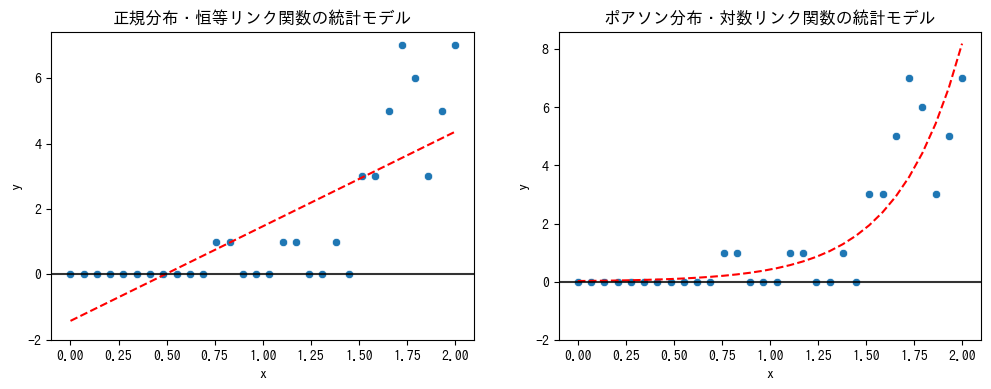

In [94]:
preds = []
titles = ["正規分布・恒等リンク関数の統計モデル","ポアソン分布・対数リンク関数の統計モデル"]
# 説明変数に切片を追加
x = sm.add_constant(data2["x"])
# 直線回帰
model = sm.GLM(data2["y"], x, family=sm.families.Gaussian()).fit()
preds.append(model.predict(x))
# ポアソン回帰
model = sm.GLM(data2["y"], x, family=sm.families.Poisson()).fit()
preds.append(model.predict(x))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1x2
for ax, pred, title in zip(axes,preds,titles):
  sns.scatterplot(data2, x="x", y="y", ax=ax)
  ax.plot(data2["x"], pred, linestyle="--",color="red")
  ax.axhline(0,color="black", alpha=0.8)
  ax.set_ylim(bottom=-2)
  ax.set_title(title)
plt.show()

<h1>3.8 この章のまとめ</h1>

・一般化線形モデルとは、ポアソン回帰やロジスティック回帰など、いくつかの制約を満たしている統計モデルの総称(3.1 例題: 個体ごとに平均種子数が異なる場合)  
・統計モデルを作るためにはデータを図示することがとても大切である(3.3 統計モデリングの前にデータを図示する)  
・一般化線形モデルは確率分布・リンク関数・線形予測子を指定する統計モデルであり、計算機を用いることでパラメータを機械的に推定できる(3.4 ポアソン回帰の統計モデル)  
・統計モデルの因子型の説明変数はダミー変数という考え方で(とりあえず)理解できる(3.5 説明変数が因子型の統計モデル)  
・一般化線形モデルでは数量型・因子型の両タイプの説明変数を同時に組み込んでよく、またその時に対数リンク関数を使うと説明変数の効果がそれぞれの積として表現できるので理解しやすい(3.6 説明変数が数量型+因子型の統計モデル)  
・一般化線形モデルの設計では、データをうまく表現できる確率分布を選ぶという発想なので「何でも正規分布」といった考え方から脱却できる(3.7 「何でも正規分布」「何でも直線」には無理がある)